In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Tuple

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
# Train paths
kmnist_train_images = "./data/kmnist-train-imgs.npz"
kmnist_train_labels = "./data/kmnist-train-labels.npz"

# Test paths
kmnist_test_images = "./data/kmnist-test-imgs.npz"
kmnist_test_labels = "./data/kmnist-test-labels.npz"

In [3]:
# Initial look at the data
kmnist_train_images = np.load(kmnist_train_images)["arr_0"]
kmnist_train_labels = np.load(kmnist_train_labels)["arr_0"]

kmnist_test_images = np.load(kmnist_test_images)["arr_0"]
kmnist_test_labels = np.load(kmnist_test_labels)["arr_0"]

print("Data Overview")
print("---------------------------------")
print(f"train_images type: {type(kmnist_train_images)}")
print(f"train_images dtype: {kmnist_train_images.dtype}")
print(f"train_images shape: {kmnist_train_images.shape}")
print(f"train_imagesn ndim: {kmnist_train_images.ndim}")
print("---------------------------------")
print(f"train_labels type: {type(kmnist_train_labels)}")
print(f"train_labels dtype: {kmnist_train_labels.dtype}")
print(f"train_labels shape: {kmnist_train_labels.shape}")
print(f"train_labels ndim: {kmnist_train_labels.ndim}")
print("---------------------------------")
print(f"test_images type: {type(kmnist_test_images)}")
print(f"test_images dtype: {kmnist_test_images.dtype}")
print(f"test_images shape: {kmnist_test_images.shape}")
print(f"test_images ndim: {kmnist_test_images.ndim}")
print("---------------------------------")
print(f"test_labels type: {type(kmnist_test_labels)}")
print(f"test_labels dtype: {kmnist_test_labels.dtype}")
print(f"test_labels shape: {kmnist_test_labels.shape}")
print(f"test_labels ndim: {kmnist_test_labels.ndim}")

Data Overview
---------------------------------
train_images type: <class 'numpy.ndarray'>
train_images dtype: uint8
train_images shape: (60000, 28, 28)
train_imagesn ndim: 3
---------------------------------
train_labels type: <class 'numpy.ndarray'>
train_labels dtype: uint8
train_labels shape: (60000,)
train_labels ndim: 1
---------------------------------
test_images type: <class 'numpy.ndarray'>
test_images dtype: uint8
test_images shape: (10000, 28, 28)
test_images ndim: 3
---------------------------------
test_labels type: <class 'numpy.ndarray'>
test_labels dtype: uint8
test_labels shape: (10000,)
test_labels ndim: 1


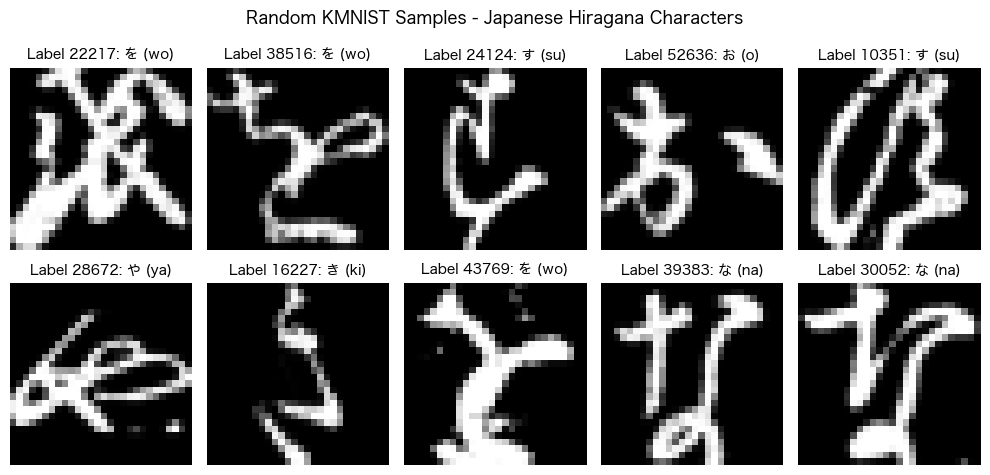

In [4]:
# Set font that supports Japanese characters since DejaVu Sans does not support it.
plt.rcParams["font.family"] = "Hiragino Sans"

kmnist_classes = {
    0: "お (o)",
    1: "き (ki)",
    2: "す (su)",
    3: "つ (tsu)",
    4: "な (na)",
    5: "は (ha)",
    6: "ま (ma)",
    7: "や (ya)",
    8: "れ (re)",
    9: "を (wo)"
}

# Plot some Hiragana Characters randomly.
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for _, ax in enumerate(axes.flat):
    rand_idx = random.randint(0, kmnist_train_images.shape[0] - 1)
    ax.imshow(kmnist_train_images[rand_idx], cmap="gray")
    label_index = kmnist_train_labels[rand_idx]
    ax.set_title(f"Label {rand_idx}: {kmnist_classes[label_index]}", fontsize=10)
    ax.axis("off")

plt.suptitle("Random KMNIST Samples - Japanese Hiragana Characters")
plt.tight_layout()
plt.show();

In [5]:
# Building the CNN

class CNN(nn.Module):
    """
    CNN (Convolutional Neural Network) for KMNIST Classification. This uses 3 convolution layers and 2 fully connected layers.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) # 1 input channel (grayscale), 32 channels, 3x3 kernel size (feature), moving filter by 1 pixel at a time, then adding the padding for 28 x 28, 32 x 28 x 28 -> 32 x 14 x 14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 64 channels, extracting more features, 14 x 14, 32 x 14 x 14 -> 64 x 7 x 7
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # 128 channels, extracting even more features, 7 x 7 -> 128 x 7 x 7
        self.bn1 = nn.BatchNorm2d(32) # Normalizes the inputs of each layer so it makes faster computations, 32 channels here
        self.bn2 = nn.BatchNorm2d(64) # Normalization, 64 channels here
        self.bn3 = nn.BatchNorm2d(128) # Normaliztion, 128 channels here
        self.pool = nn.MaxPool2d(2) # 2x2 pooling to extract the essential features
        self.dropout = nn.Dropout2d(0.25) # This drops 25% of the features so basically that the model can "learn" better

        self.fc1 = nn.Linear(128 * 3 * 3, 128) # Hyperparameter of 128 - fully connected layers
        self.fc2 = nn.Linear(128, 10) # 10 is the output - 10 different outputs for KMNIST

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # Fully Connected Layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [6]:
# Initializing the CNN
cnn = CNN()

In [7]:
# Image Transformation Pipeline for PyTorch. Transforms the data to tensors and we also will add some noise to the train dataset. Lastly, we will normalize the values.
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random generic transformations to the dataset so it prevents overfitting and also the varities to make the model more robust. 10 degree rotation, moves image randomly up to 10% of the pixels, and random scaling of 90-110%.
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Changes the contrast and brightness by ±10%.
    transforms.Normalize((0.1918,), (0.3483,)) # Normalize the values - these are the values for KMNIST (mean and SD).
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1918,), (0.3483,))
])

In [8]:
# The KMNIST Dataset class. We created a custom Dataset class as images are labels are split for both test and training.
class KMNISTDataset(Dataset): # PyTorch Dataset is just a class that represents our dataset.
    def __init__(self, images, labels, transform):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.transform(self.images[index])
        label = self.labels[index]

        return image, label

In [9]:
# Let's split the kmnist_train_images (the train images and labels) into train and validation sets before we create the dataset
# 80% to training and 20% to validation
train_split = 0.8

len_kminst_train = len(kmnist_train_images) 
combined_train_kmnist = list(zip(kmnist_train_images, kmnist_train_labels)) # Zipping and making it a list
random.shuffle(combined_train_kmnist) # Random shuffle but together
split_idx = int(train_split * len(combined_train_kmnist)) # Splitting index

kminst_train_dataset = combined_train_kmnist[:split_idx] # Train dataset
kminst_validation_dataset = combined_train_kmnist[split_idx:] # Validation dataset

kmnist_train_images, kmnist_train_labels = zip(*kminst_train_dataset) # Unzip
kminst_validation_images, kmnist_validation_labels = zip(*kminst_validation_dataset) # Unzip

In [10]:
# Creating the Dataset
train_dataset = KMNISTDataset(kmnist_train_images, kmnist_train_labels, train_transforms)
val_dataset = KMNISTDataset(kminst_validation_images, kmnist_validation_labels, val_test_transforms)
test_dataset = KMNISTDataset(kmnist_test_images, kmnist_test_labels, val_test_transforms)

In [11]:
# Create a class that trains, validates, and tests the model

class TrainValTest:
    def __init__(self, model, train_data, val_data, test_data, num_epochs, batch_size=32, lr=0.001):
        # Initial Setup
        self.model = model
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        
        # DataLoaders
        self.train_loader = DataLoader(self.train_data, self.batch_size, shuffle=True) # DataLoaders help feed data in to our model in manageable "chunks". We want to shuffle our data for training, and our batch size is a hyperparameter - how many data samples to look at.
        self.val_loader = DataLoader(self.val_data, self.batch_size, shuffle=False) # shuffle = False in this case as this is a test dataset.
        self.test_loader = DataLoader(self.test_data, self.batch_size, shuffle=False)

        # Setting Up Loss Function and Optimizer
        self.loss_fn = nn.CrossEntropyLoss() # Cross Entropy Loss - common for classification problems and basically compares model's output to ground truth - lower loss is better.
        self.optimizer = optim.Adam(self.model.parameters(), lr) # Function to update model's weight to up the performance/minimize loss. Learning Rate (of 0.001) is how much the "step" the optimizer takes to update the model's weights when learning the model.

    def fire(self): # Method to "fire" the training and validation

        self.train_loss_list = []
        self.val_loss_list = []
        self.accuracy_list = []

        # Training
        for epoch in range(self.num_epochs):

            running_loss = 0

            for images, labels in self.train_loader:
            
                self.optimizer.zero_grad() # Erase accumulated gradients
                outputs = self.model(images) # Forward pass
                train_loss = self.loss_fn(outputs, labels) # Loss Function
                train_loss.backward() # Back propogation 
                self.optimizer.step() # Update the weight here using the optimizer

                running_loss += train_loss.item() * labels.size(0) # Accumulating the total loss for the epoch

            self.train_loss_list.append(running_loss / len(self.train_loader.dataset)) 

            print(f"Epoch {epoch + 1}, Train Loss: {self.train_loss_list[epoch]}")

            # Validating
            self.model.eval() # Evaluation mode

            val_loss = 0
            num_correct = 0
            total_val_samples = 0

            with torch.no_grad(): # Disables gradient calcuation since we aren't training
                for images, labels in self.val_loader:

                    outputs = self.model(images) # Forward Pass
                    val_loss += self.loss_fn(outputs, labels).item() # Loss Function
                    _, pred = torch.max(outputs.data, dim=1) # Getting index of max class score
                    num_correct += ((pred == labels).sum().item()) # Counts correct predictions and summing them up
                    total_val_samples += labels.size(0) # Counting the total number of validation samples processed

            val_loss /= len(self.val_loader)
            accuracy = num_correct / total_val_samples
            self.val_loss_list.append(val_loss)
            self.accuracy_list.append(accuracy)

            print(f"Epoch {epoch + 1}, Validation Loss: {self.val_loss_list[epoch]}, Accuracy: {self.accuracy_list[epoch]}")

    def test_model_performance(self): # Tests the model performance with the test data, similar code to the validation logic
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()

        test_loss_list = []
        accuracy_list = []

        with torch.no_grad():
            test_loss = 0
            num_correct = 0
            total_val_samples = 0

            with torch.no_grad(): 
                for images, labels in self.test_loader:

                    outputs = self.model(images) 
                    test_loss += loss_fn(outputs, labels).item() 
                    _, pred = torch.max(outputs.data, dim=1) 
                    num_correct += ((pred == labels).sum().item()) 
                    total_val_samples += labels.size(0) 
                    
            test_loss /= len(self.test_loader)
            accuracy = num_correct / total_val_samples
            test_loss_list.append(test_loss)
            accuracy_list.append(accuracy)

            avg_test_loss = np.mean(test_loss_list)
            avg_accuracy = np.mean(accuracy_list)

        print(f"Average Test Loss: {avg_test_loss}, Average Accuracy: {avg_accuracy}")

    def visualize(self): # Visualize the train loss, validation loss, and accuracy

        plt.figure(figsize=(10, 5))

        plt.plot(range(1, self.num_epochs + 1), self.train_loss_list, label="Train Loss")
        plt.plot(range(1, self.num_epochs + 1), self.val_loss_list, label= "Validation Loss")
        plt.plot(range(1, self.num_epochs + 1), self.accuracy_list, label="Accuracy")

        plt.xlabel("Epochs")
        plt.ylabel("Value")
        plt.legend()

        plt.show();

In [12]:
# Run the model. For now, let's do it on 10 Epochs.
num_epochs = 10

train_val_test = TrainValTest(cnn, train_dataset, val_dataset, test_dataset, num_epochs)

train_val_test.fire()

Epoch 1, Train Loss: 0.39675705740042033
Epoch 1, Validation Loss: 0.07429287092729162, Accuracy: 0.9769166666666667
Epoch 2, Train Loss: 0.1213458832828328
Epoch 2, Validation Loss: 0.0502298998713959, Accuracy: 0.9844166666666667
Epoch 3, Train Loss: 0.09844083273872578
Epoch 3, Validation Loss: 0.04431324018186812, Accuracy: 0.9881666666666666
Epoch 4, Train Loss: 0.08874713030273172
Epoch 4, Validation Loss: 0.04950531163211175, Accuracy: 0.985
Epoch 5, Train Loss: 0.07404221254353373
Epoch 5, Validation Loss: 0.04753573610721772, Accuracy: 0.9873333333333333
Epoch 6, Train Loss: 0.06890905311253058
Epoch 6, Validation Loss: 0.03642229609272908, Accuracy: 0.99
Epoch 7, Train Loss: 0.059641011906285714
Epoch 7, Validation Loss: 0.04065128041135419, Accuracy: 0.98925
Epoch 8, Train Loss: 0.05909465650015045
Epoch 8, Validation Loss: 0.04402943386175078, Accuracy: 0.9885
Epoch 9, Train Loss: 0.054476220135130766
Epoch 9, Validation Loss: 0.03298935708363691, Accuracy: 0.99075
Epoch 10

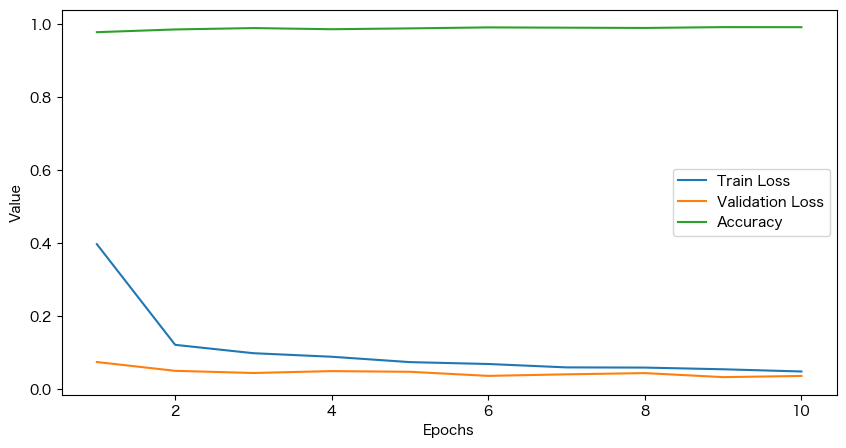

In [13]:
# Visualize the training loss, validation loss, and the accuracy of the model.
train_val_test.visualize()

In [14]:
# Test the model with the test dataset
train_val_test.test_model_performance()

Average Test Loss: 0.15425397091689266, Average Accuracy: 0.965
